In [1]:
from IPython.display import HTML

HTML("""
<button id="code-show-switch-btn">スクリプトを非表示にする</button>

<script>
var code_show = true;

function switch_display_setting() {
    var switch_btn = $("#code-show-switch-btn");
    if (code_show) {
        $("div.input").hide();
        code_show = false;
        switch_btn.text("スクリプトを表示する");
    }else {
        $("div.input").show();
        code_show = true;
        switch_btn.text("スクリプトを非表示にする");
    }
}

$("#code-show-switch-btn").click(switch_display_setting);
</script>
""")

In [2]:
# For mac-OS environment
import stata_setup
stata_setup.config("/Applications/stata", "mp")


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       MP—Parallel Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Single-user 4-core  perpetual
Serial number: 501706353196
  Licensed to: Kobayashi Ryuki
               Keio University

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. More than 2 billion observations are allowed; see help obs_advice.
      3. Maximum number of variables is set to 5,000 but can be increased;
          see help set_maxvar.


In [3]:
# # For windows environment
# import numpy as np
# import matplotlib.pyplot as plt
# import markdown
# import pandas as pd
# import counterfactual
# import warnings
# warnings.filterwarnings('ignore')
# pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_columns', 100)
# pd.options.display.precision = 4
# import stata_setup
# stata_setup.config("C://Program Files//Stata17", "be")
# md = markdown.Markdown(extensions=['pymdownx.tabbed'])

# Local macros for all graph

In [35]:
%%stata
local ltp=" plot1(lc(midblue) lpattern(solid)  lwidth(thick)) plot2(lc(navy) lpattern(solid)  lwidth(thick))"
local s1=monthly("2019m4","YM")
local s2=monthly("2021m4","YM")


. local ltp=" plot1(lc(midblue) lpattern(solid)  lwidth(thick)) plot2(lc(navy) 
> lpattern(solid)  lwidth(thick))"

. local s1=monthly("2019m4","YM")

. local s2=monthly("2021m4","YM")

. 


# 1. Introduction

## Figure 1: Suicide Trends in Japan: Impact of COVID-19

### Figure 1 (a) Yearly Trends in Suicide Incidents by Gender


. qui{

. 


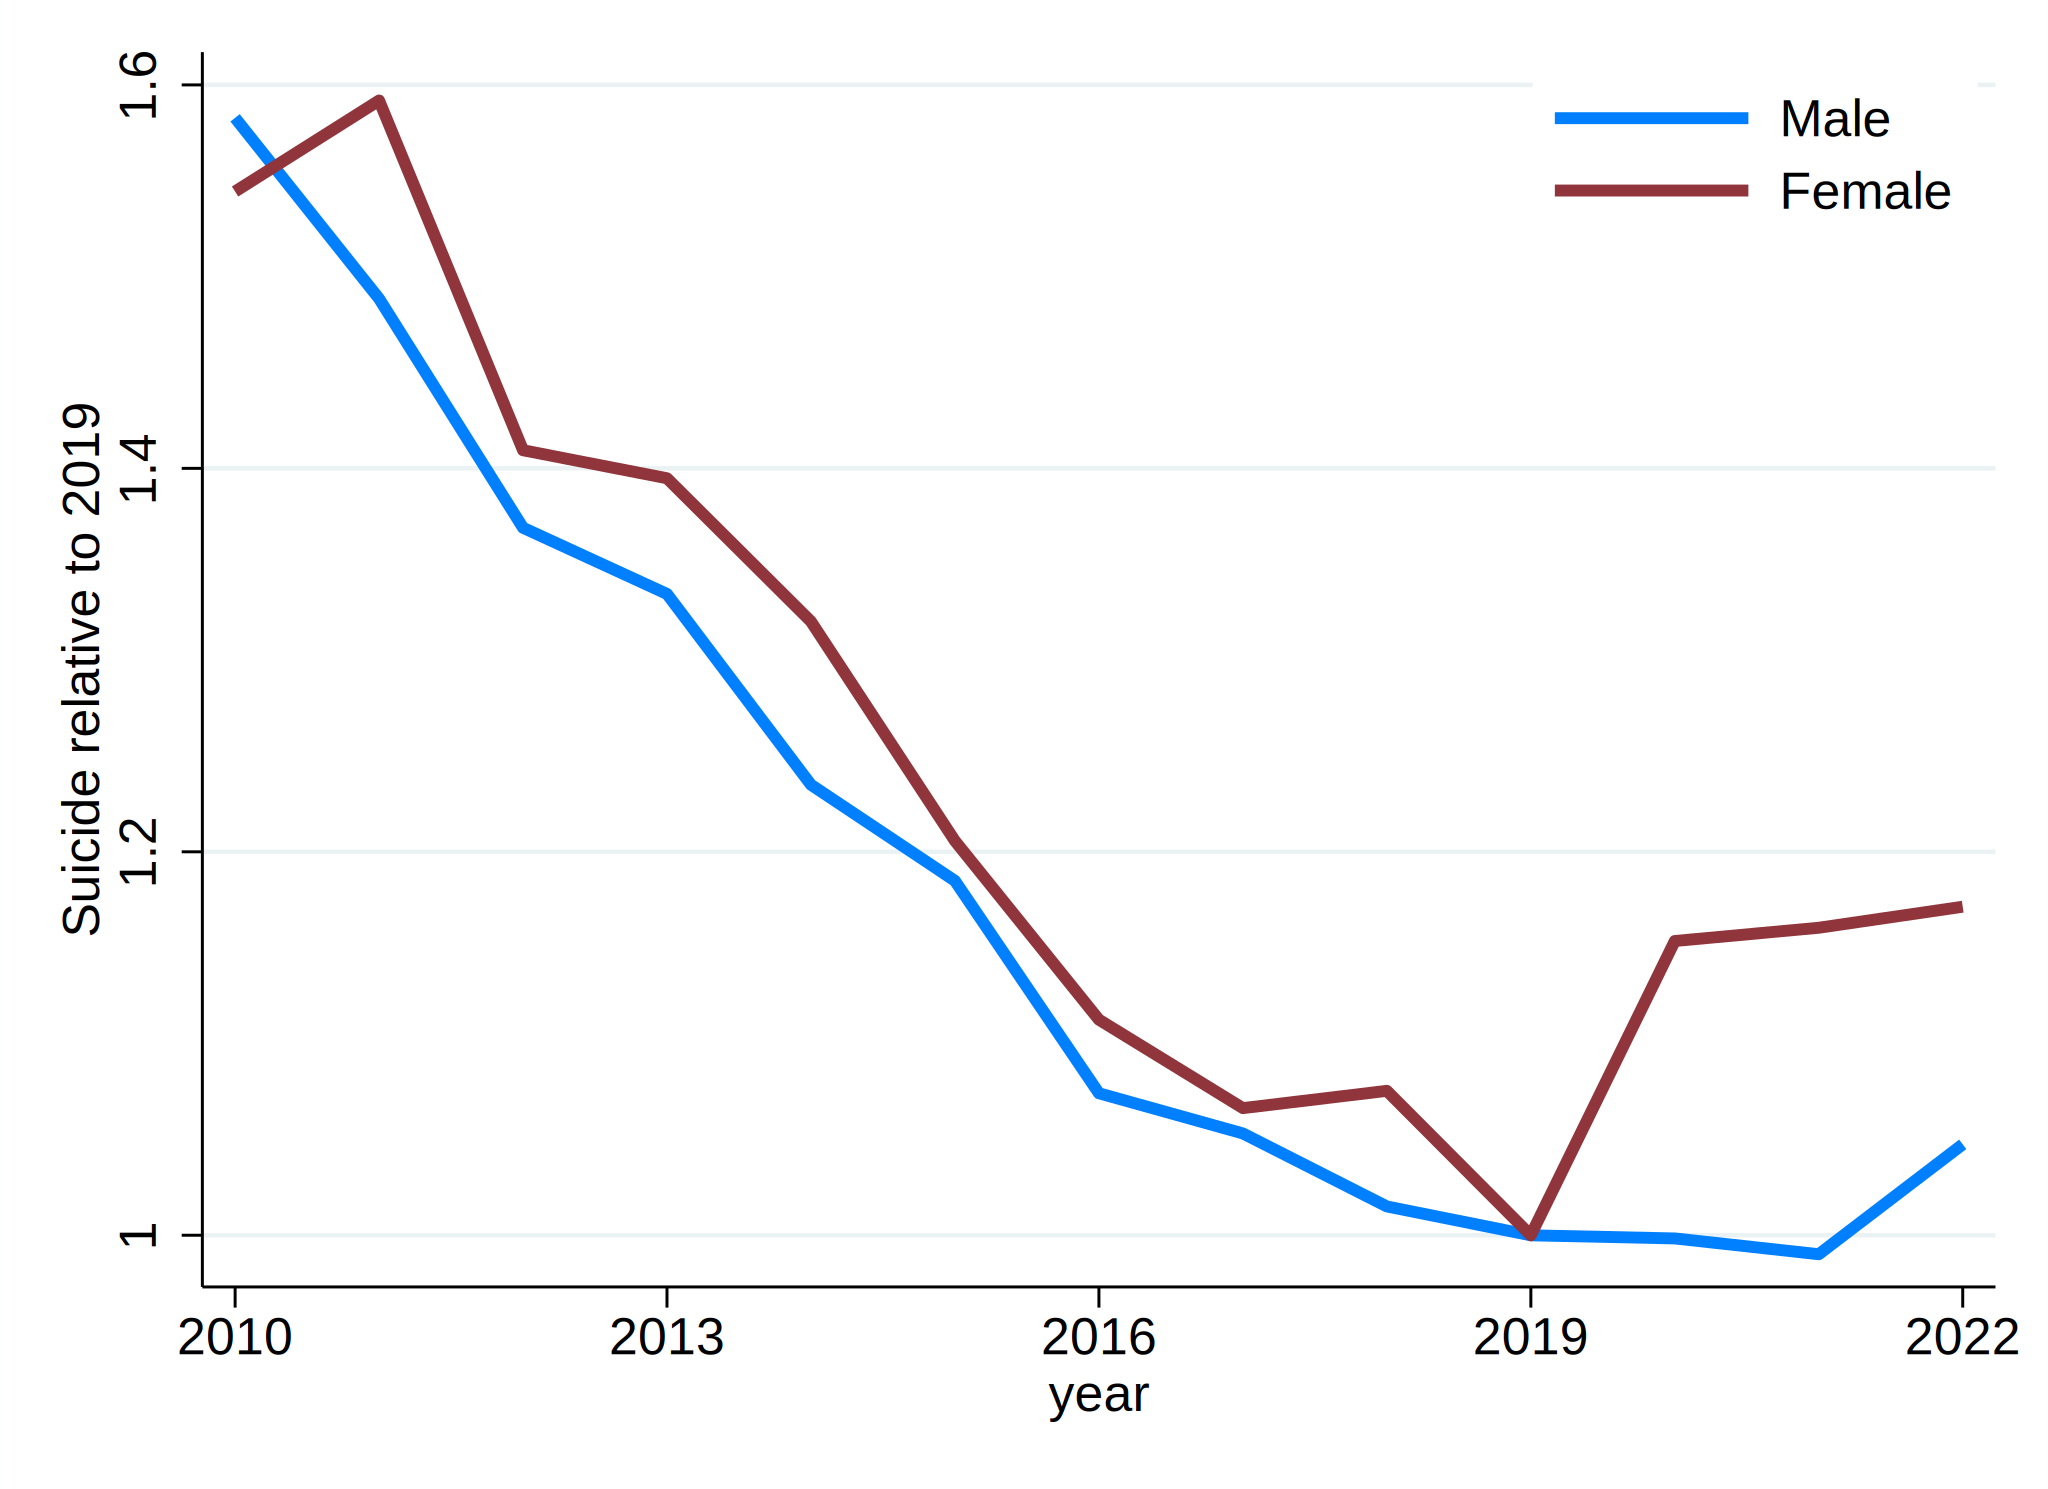

In [45]:
%%stata
qui{
use ../data/suicide_trend.dta, clear

graph twoway (line male year, ytitle("Male")) (line female year, ytitle("Female",axis(2)) yaxis(2)), legend(order(1 "Male" 2 "Female") pos(6) col(2))
graph save trend1987_2022.gph, replace
graph export trend1987_2022.jpg, replace

keep if year == 2019
keep female male
rename female female2019
rename male male2019 
gen unity=1
save temp, replace

use ../data/suicide_trend.dta, clear
gen unity=1
merge m:1 unity using temp.dta
gen f_relative2019 = (female)/female2019
gen m_relative2019 = (male)/male2019

#delimit ;
graph twoway 
    (line m_relative2019 year if year >=2010, ytitle("Suicide relative to 2019 ") lwidth(thick)  lcolor(midblue)) 
    (line f_relative2019 year if year >=2010, lwidth(thick) lcolor(maroon)), 
    legend(order(1 "Male" 2 "Female") pos(2) ring(0) col(1) region(lstyle(none))) 
    graphregion(color(white))
    xlabel(2010(3)2022);
graph save ../figuretable/introduction/trend_relative2019.gph, replace;
graph export ../figuretable/introduction/trend_relative2019.jpg, width(3200) height(1800) replace;
};

### Figure 1 (b) Age-specific Percentage Changes in Female Suicide Incidents


. qui{

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
pctChange~20 |          1    42.66055           .   42.66055   42.66055

. 


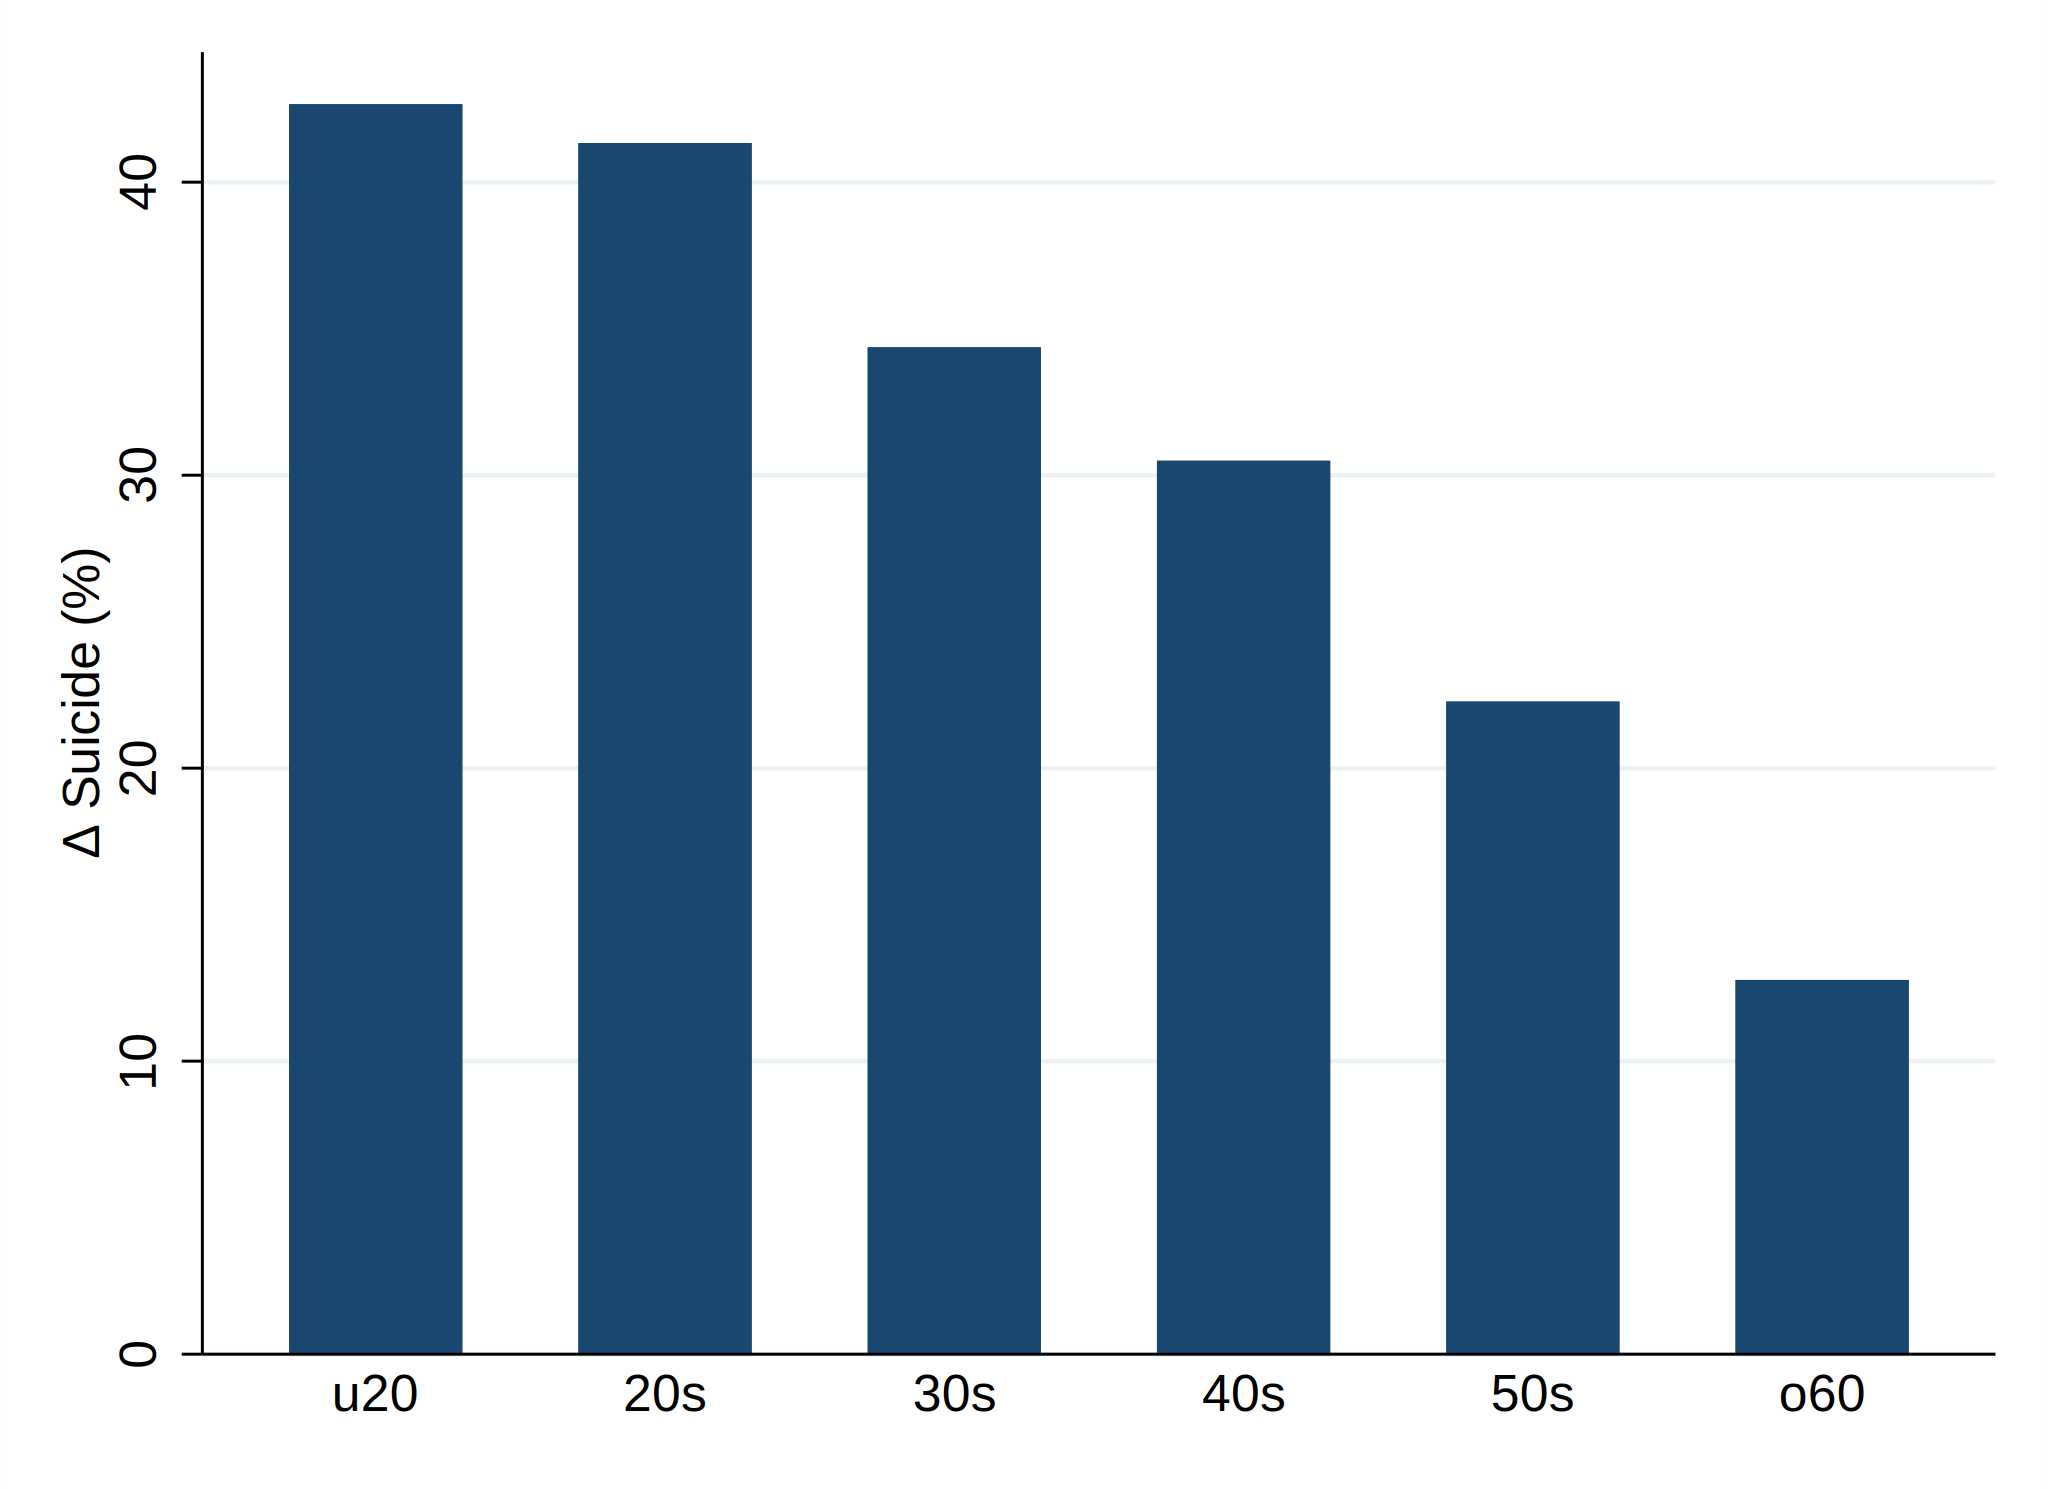

In [10]:
%%stata
qui{
use ../data/suicide_analysis_data_static, clear

collapse (sum) suicide_f*, by(covid)

tsset covid

gen suicide_f_pctChange = ((suicide_f - L.suicide_f)/L.suicide_f)*100

rename suicide_f_20_29 suicide_f_20s
rename suicide_f_30_39 suicide_f_30s
rename suicide_f_40_49 suicide_f_40s
rename suicide_f_50_59 suicide_f_50s

local pctChange_vars = ""
foreach x in u20 20s 30s 40s 50s o60 {
	gen pctChange_suicide_f`x' = ((suicide_f_`x' - L.suicide_f_`x')/L.suicide_f_`x')*100
	label variable pctChange_suicide_f`x' "`x'"
	local pctChange_vars = "`pctChange_vars'" + " pctChange_suicide_f`x'"
}
drop if missing(suicide_f_pctChange)
noi:summarize pctChange_suicide_fu20

reshape long pctChange_suicide_f, i(covid) j(age_group) string

drop covid
sort pctChange_suicide_f
graph bar pctChange_suicide_f, over(age_group, sort(pctChange_suicide_f) des) ytitle("{&Delta} Suicide (%)") graphregion(color(white))
graph save ../figuretable/introduction/descriptive_pctChange_suicide_f.gph,replace
graph export ../figuretable/introduction/descriptive_pctChange_suicide_f.jpg, width(3200) height(1800) replace
}

# 2. Empirical Model

## Figire 2: Relevance and Pre-trend: Two-Type Case

### Figure 2 (a): Relevance: Commuting Ratio vs. Stay-at-Home


. qui{

. 
. graph save  ../figuretable/methods/commuter_ratio_stay_home_scatter.gph,repla
> ce
file ../figuretable/methods/commuter_ratio_stay_home_scatter.gph saved

. graph export ../figuretable/methods/commuter_ratio_stay_home_scatter.jpg, wid
> th(3200) replace
file ../figuretable/methods/commuter_ratio_stay_home_scatter.jpg written in JPE
> G format

. 


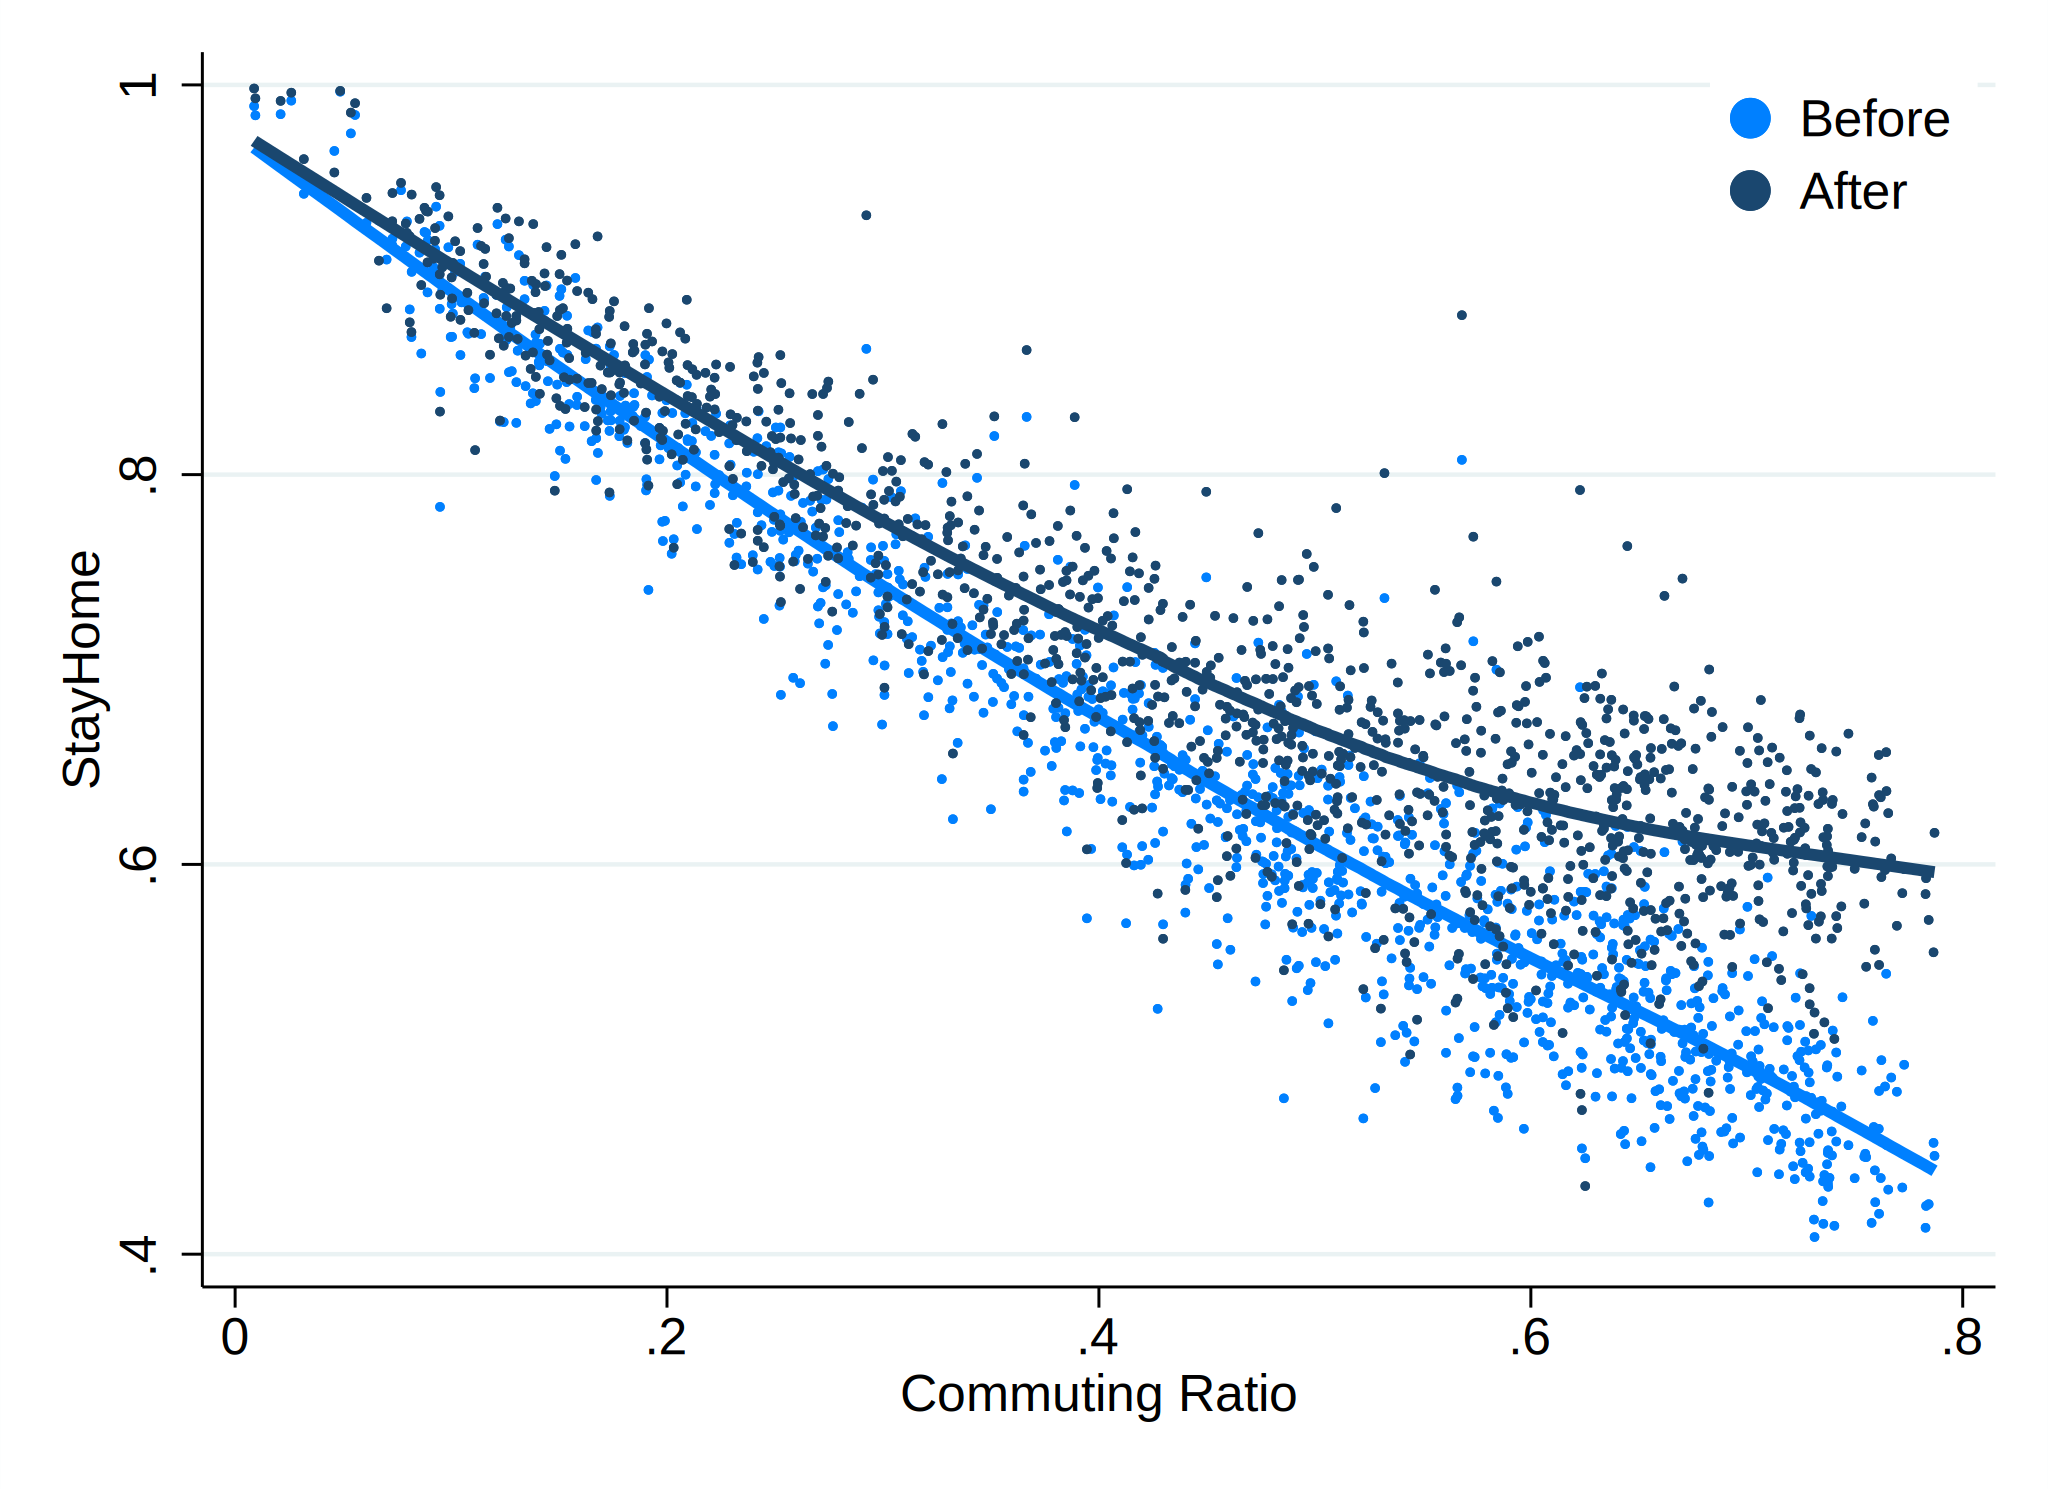

In [46]:
%%stata
qui{
use ../data/suicide_analysis_data,clear
keep if year==2019|year==2020|year==2021
drop if (year==2019 & month<=3)|(year==2021 & month>=4)
/* stay_home adjustment */
replace stay_home=1 if stay_home>1 & stay_home~=.          
collapse (mean) stay_home commuter_ratio (first) cityname prefecture,by(citycode covid)
#delimit ;    
twoway (scatter stay_home commuter_ratio if covid==0, msize(tiny)  mc(midblue)) || 
    (scatter stay_home commuter_ratio if covid==., msize(large)  mc(midblue)) || 
    (lowess stay_home commuter_ratio if covid==0, lwidth(thick)  lcolor(midblue)) || 
    (scatter stay_home commuter_ratio if covid==1 , msize(tiny)  mc(navy)) || 
    (scatter stay_home commuter_ratio if covid==. , msize(large)  mc(navy)) ||     
    (lowess stay_home commuter_ratio if covid==1, lwidth(thick)  lcolor(navy) lpattern(solid)), 
    legend(label(2 "Before")label(5 "After") order (2 5) position(2) ring(0) col(1) region(lstyle(none))) ytitle("StayHome") 
    xtitle(Commuting Ratio) name(scatter1,replace) graphregion(color(white));
#delimit cr
}

graph save  ../figuretable/methods/commuter_ratio_stay_home_scatter.gph,replace
graph export ../figuretable/methods/commuter_ratio_stay_home_scatter.jpg, width(3200) replace

### Figure 2 (b): Pre-trend: Suicide Trends by Commuting Patterns


. qui{

. 


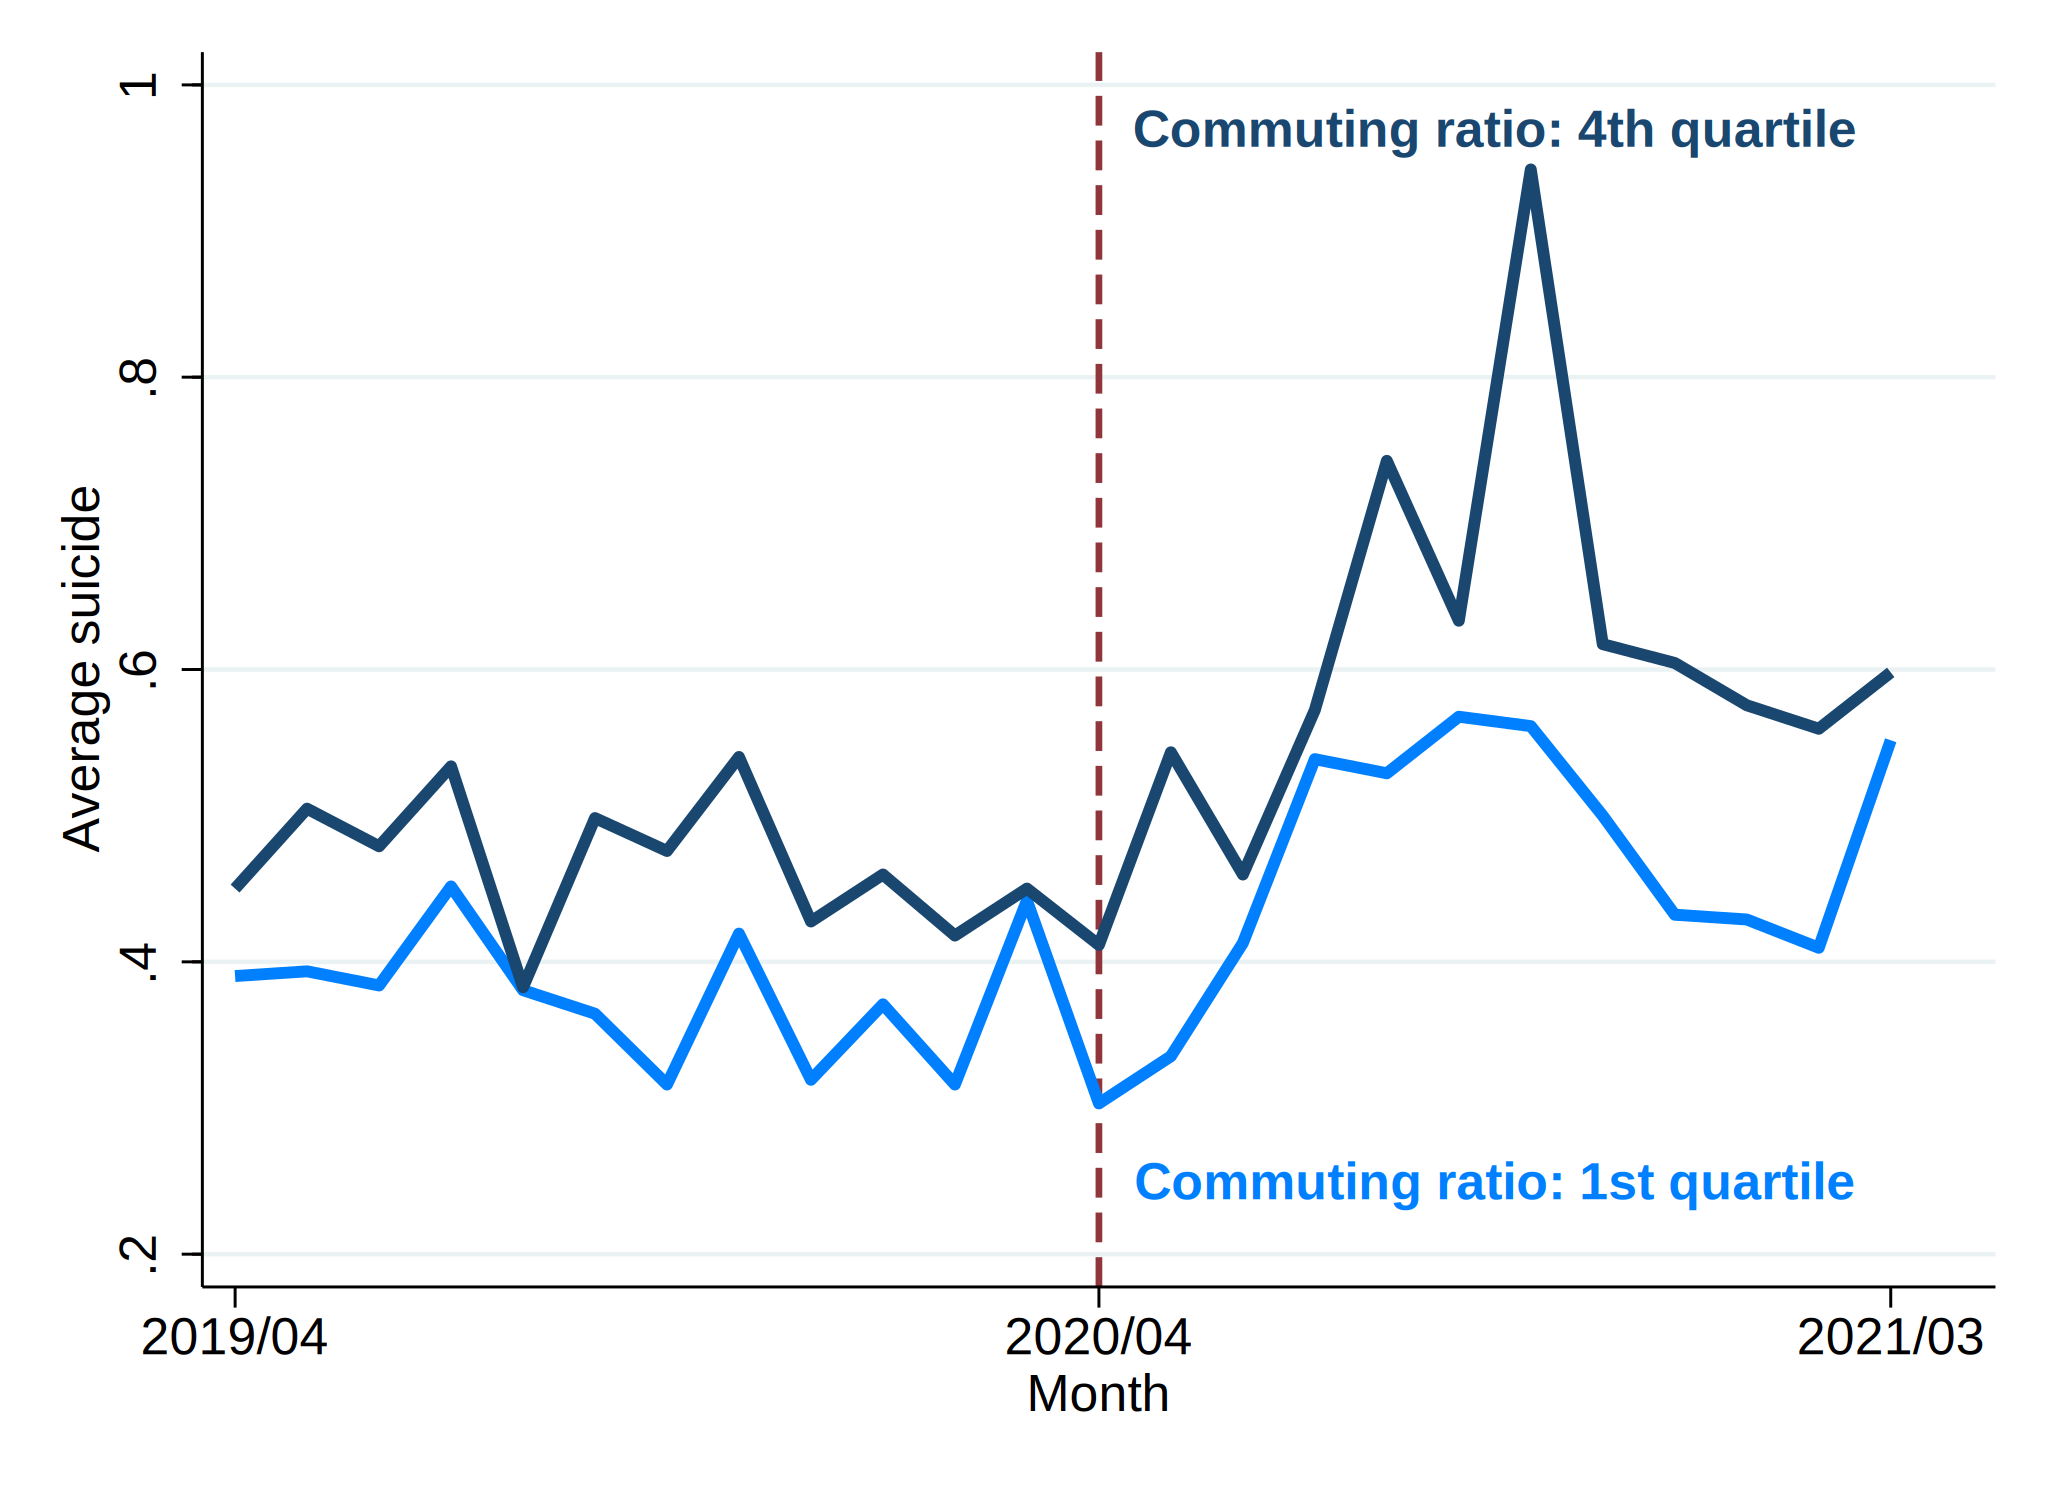

In [36]:
%%stata
qui{
use ../data/suicide_analysis_data,clear    

keep if year>=2019 & year<=2021
drop if (year==2019 & month<=3)|(year==2021 & month>=4)

/* stay_home adjustment */
replace stay_home=1 if stay_home>1 & stay_home~=.          
collapse (mean) commuter_ratio suicide_f, by(modate commuter_type)
xtset commuter_type modate
keep if commuter_type==1|commuter_type==4    

# delimit ;
xtline suicide_f, 
    i(commuter_type) t(modate) overlay 
    name(suicide_rate_f, replace) saving(suicide_rate_f,replace)  
    xtitle("Month") xlabel(711 "2019/04" 723 "2020/04" 734 "2021/03") 
    ytitle("Average suicide") 
    `ltp' legend(off) 
    ylabel(0.2(.2)1) ymtick(0.2(.2)1) xsc(r(`s1' `s2'))
    xline(723, lpattern(dash) lcolor(maroon) lwidth(medthick)) 
    text(0.97 728.5 "{bf:Commuting ratio: 4th quartile}", color(navy)) 
	text(0.25 728.5 "{bf:Commuting ratio: 1st quartile}", color(midblue)) 
    graphregion(color(white));
    
graph save  ../figuretable/methods/female_suicide_commuting_ratio_percentile.gph,replace;
graph export ../figuretable/methods/female_suicide_commuting_ratio_percentile.jpg, width(3200) replace;
};

# 3. Data

##  Figure 3: Stay-at-Home Trends and Distribution Before and After COVID-19

### Figure 3 (a) Trend


. qui{

. graph save ../figuretable/methods/stay_home_trend.gph,replace;
file ../figuretable/methods/stay_home_trend.gph saved

. graph export ../figuretable/methods/stay_home_trend.jpg, width(3200) replace;
file ../figuretable/methods/stay_home_trend.jpg written in JPEG format

. 


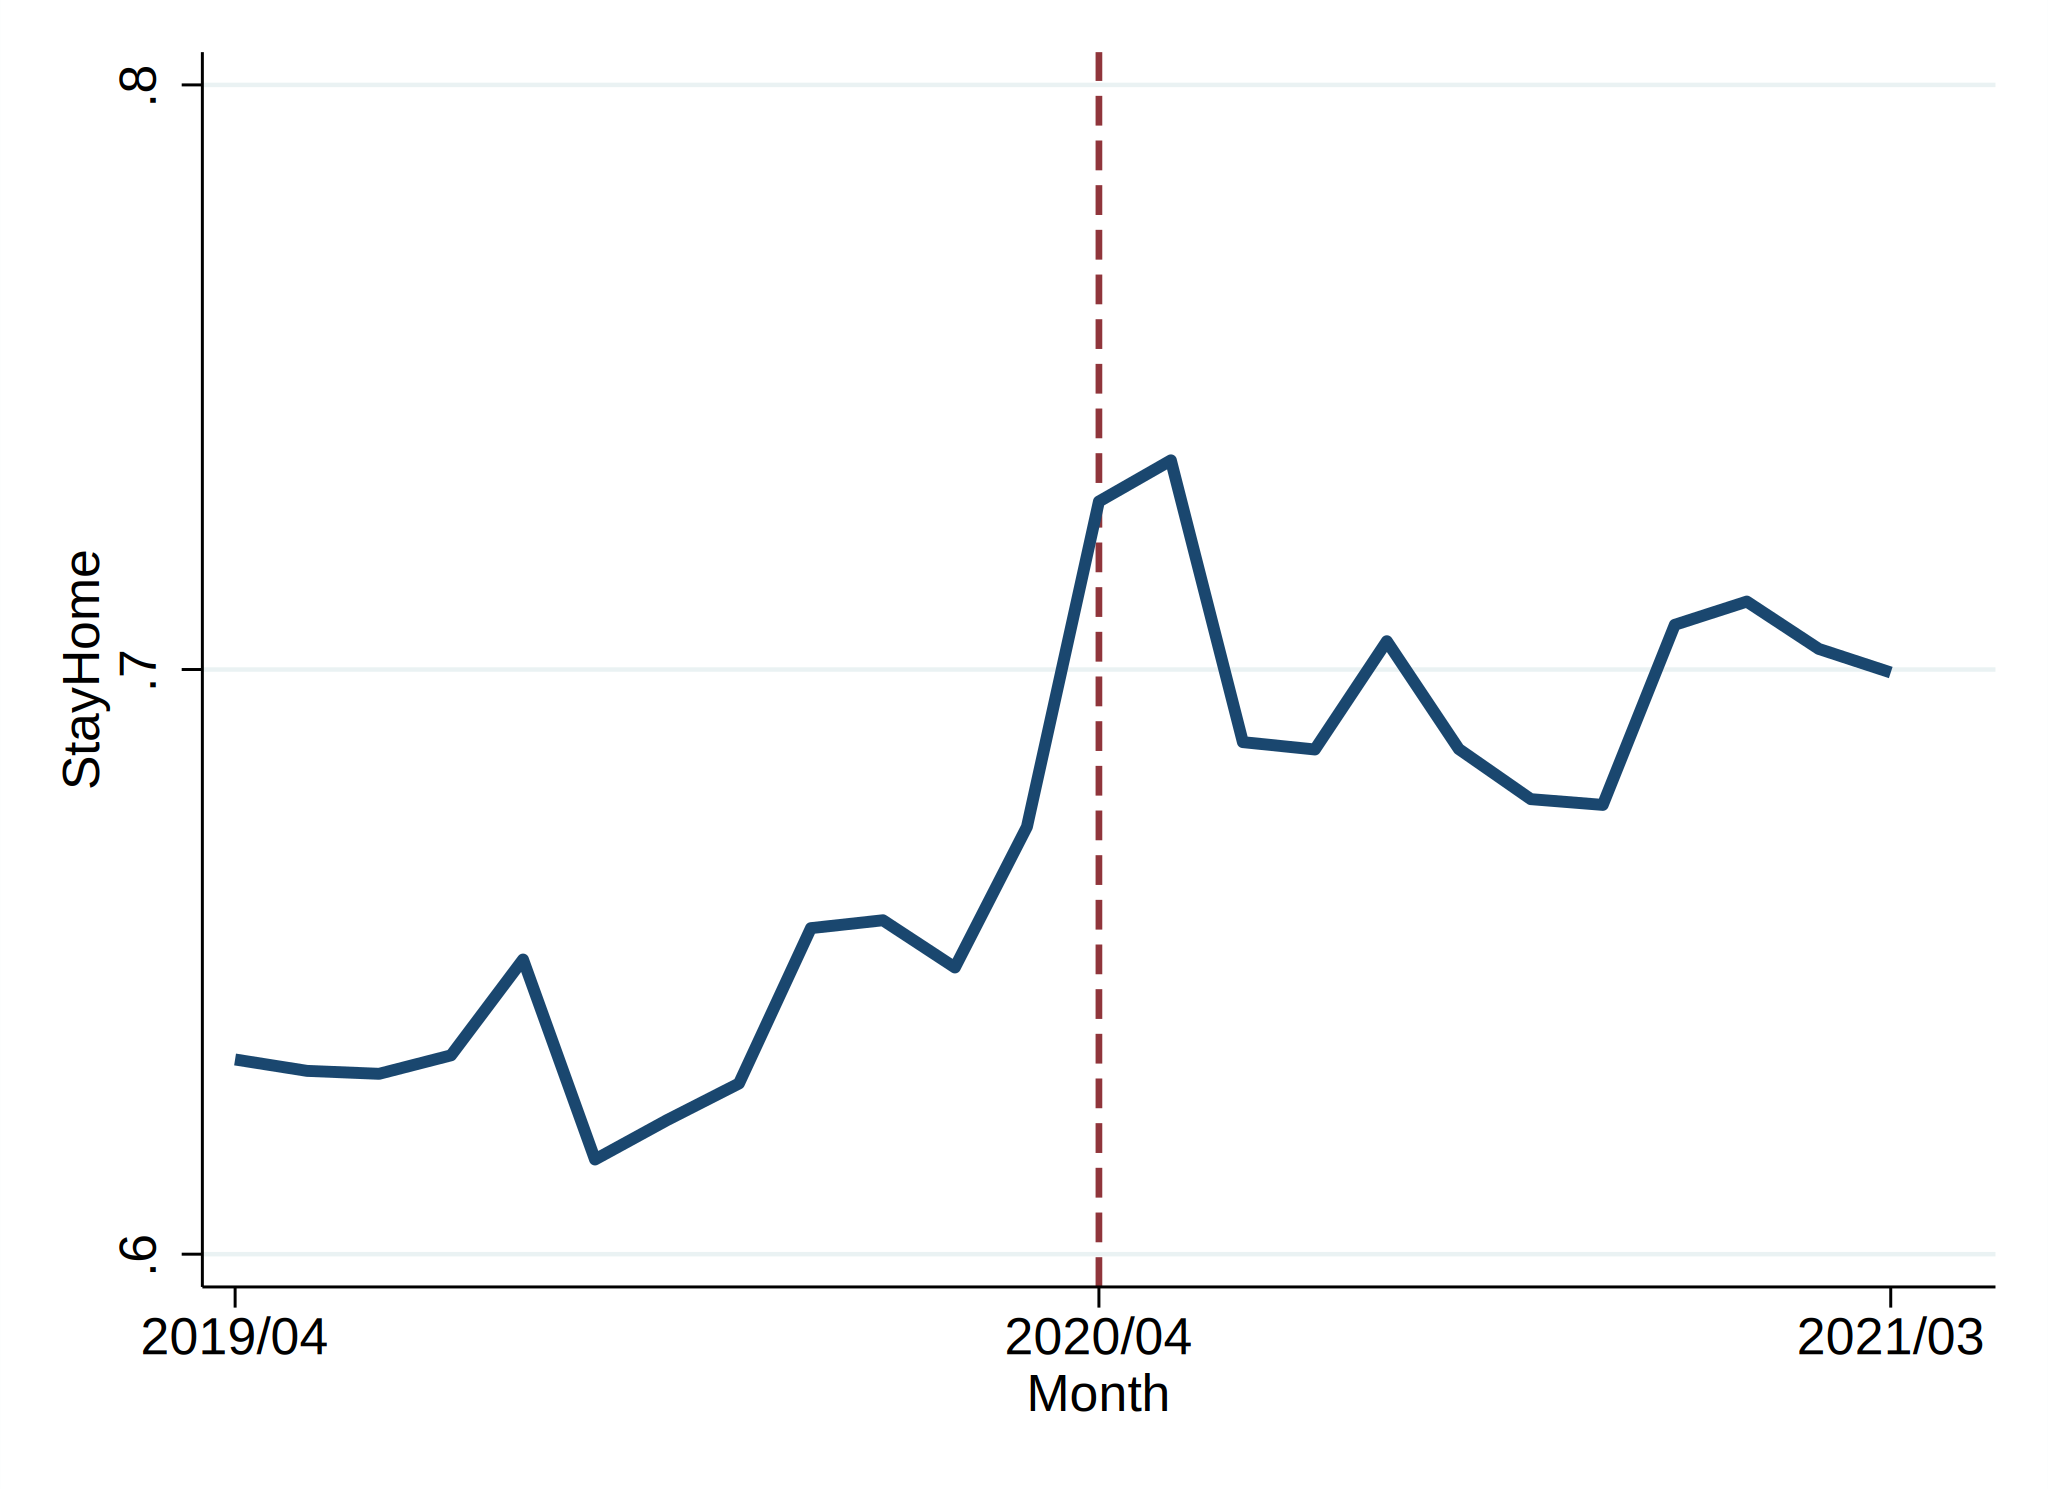

In [39]:
%%stata
qui{
capture restore
use ../data/suicide_analysis_data,clear
keep if year>=2019 & year<=2021
drop if (year==2019 & month<=3)|(year==2021 & month>=4)
/* stay_home adjustment */
replace stay_home=1 if stay_home>1 & stay_home~=.        
preserve
collapse (mean) stay_home,by(modate)

#delimit ;
twoway (line stay_home modate, ysc(range(0.6 .8) ) ylabel(0.6(0.1).8) lwidth(thick))
    , xline(723, lpattern(dash) lcolor(maroon) lwidth(medthick)) 
    legend(off) xtitle("Month") ytitle("StayHome") xsc(r(`s1' `s2')) name(stay_home_trend,replace)
    xlabel(711 "2019/04" 723 "2020/04" 734 "2021/03") graphregion(color(white));
};

graph save ../figuretable/methods/stay_home_trend.gph,replace;
graph export ../figuretable/methods/stay_home_trend.jpg, width(3200) replace;


### Figure 3 (b): Distribution


. qui{

. graph save ../figuretable/methods/stay_home_distribution.gph,replace
file ../figuretable/methods/stay_home_distribution.gph saved

. graph export ../figuretable/methods/stay_home_distribution.jpg, width(3200) r
> eplace
file ../figuretable/methods/stay_home_distribution.jpg written in JPEG format

. 


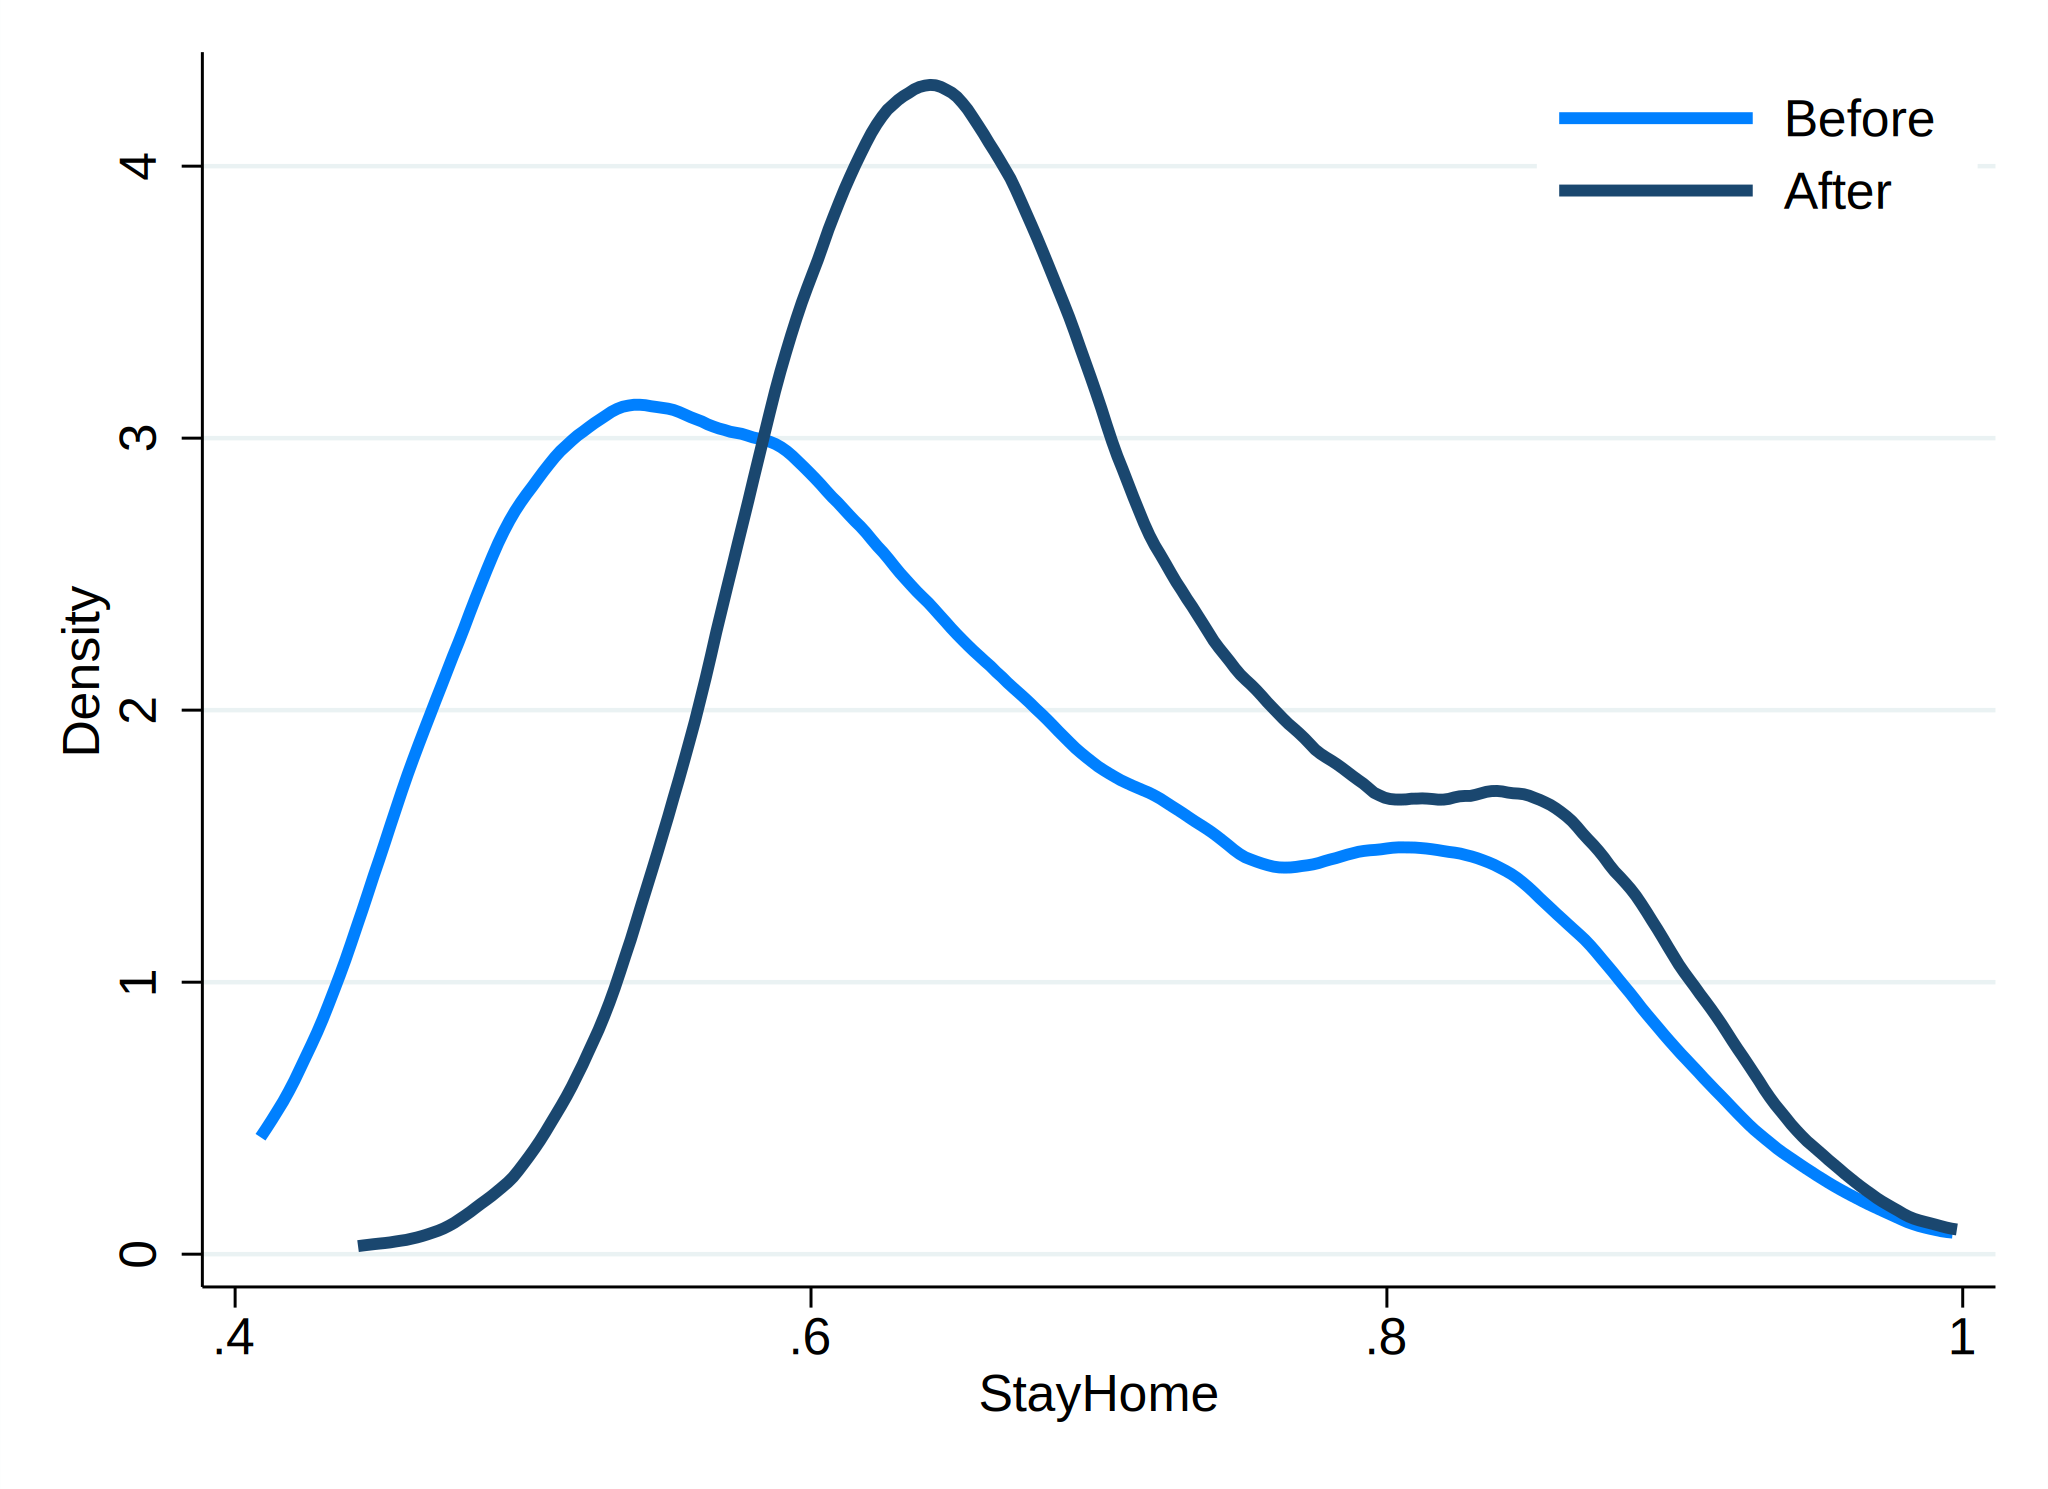

In [40]:
%%stata
qui{
use ../data/suicide_analysis_data,clear
keep if year==2019|year==2020
keep if year==2019|year==2020
drop if (year==2019 & month<=3)|(year==2021 & month>=4)
/* stay_home adjustment */
replace stay_home=1 if stay_home>1 & stay_home~=.         
collapse (mean) stay_home (first) cityname prefecture,by(citycode covid)
twoway (kdensity stay_home if covid==0,lc(midblue) lwidth(thick))|| ///
    (kdensity stay_home if covid==1,lc(navy) lwidth(thick)), ///
    legend(label(1 "Before ") label(2 "After ") position(1) ring(0) col(1) region(lstyle(none))) ///
    ytitle("Density") xtitle("StayHome") name(stay_home_distribution,replace) graphregion(color(white))

}
graph save ../figuretable/methods/stay_home_distribution.gph,replace
graph export ../figuretable/methods/stay_home_distribution.jpg, width(3200) replace